# Exercise 3

### Group: Nikolai Rasmus Sætren, Thomas Olaussen, Tiago Alexandre Alcobia Pereira

In [389]:
%matplotlib inline
import numpy as np
from numpy import sin,cos
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

In [390]:
class IBVP(object): 
    def __init__(self, ga=0, gb=0, a=0, b=1, u0=0, f=0, s = 1, r = 1, c = 1):
        self.ga = ga       # left boundary condition
        self.gb = gb       # right boundary condition
        self.a = a         # left boundary position 
        self.b = b         # right boundary position 
        self.u0 = u0       # initial condition
        self.f = f         # right hand side
        self.s = s         # volatility (sigma)
        self.r = r         # interest rate
        self.c = c         # dividends and correlation

In [391]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = np.diag(v*e[1:],-1)+np.diag(d*e)+np.diag(w*e[1:],1)
    return A

In [392]:
def crank_nicholson(IBVP, M = 10, N = 10, T = 1):
    # Solve the Black-Scholes equation
    h = (IBVP.b-IBVP.a)/M     # Stepsize in space
    k = T/N                   # Stepsize in time

    print(f'h={h:.4f}, k={k:.4f}')
    
    x = np.linspace(IBVP.a, IBVP.b, M+1)  # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)              # Gridpoints on the t-axis   
    U = np.zeros((M+1,N+1))               # Array to store the solution, boundaries included. 
    f = np.zeros((M-1,N+1))               # RHS
    g = np.zeros((M-1,N+1))               # B.C

    tv,xv= np.meshgrid(t,x[1:-1])

    U[:,0] = IBVP.u0(x)                   # Initial values
    U[0,:] = IBVP.ga(t)                   # Boundary values
    U[-1,:] = IBVP.gb(t)                  # Boundary values
    f = IBVP.f(xv,tv)

    
    g[0] = 1/2*(IBVP.s**2-IBVP.r)*U[0]
    g[-1] = (M-1)/2*(IBVP.s**2*(M-1)+IBVP.r)*U[-1]


    # Define the diagonals of A
    v = np.array([1/2*(IBVP.s**2*m**2-IBVP.r*m) for m in range(2,M)])
    d = np.array([-(IBVP.s**2*m**2+IBVP.c) for m in range(1,M)])
    w = np.array([1/2*(IBVP.s**2*m**2+IBVP.r*m) for m in range(1,M-1)])

    A = tridiag(v,d,w,M-1)                # Construct A from diagonals
    I = np.identity(M-1)

    # print(A)
    # print(g)
    # print(f)

    for n in range(N):
        U[1:-1,n+1] = np.linalg.solve((I-k/2*A),(I+k/2*A)@U[1:-1,n]+k/2*(f[:,n]+f[:,n+1]+g.T[n]+g.T[n+1]))
    
    return x,t,U





In [393]:
def plot_solution(x, t, U, txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt)

In [394]:
K = 3
R = 1
s = 0.05
r = 0.045**2
c = 0.1

def g1(x):
    return cos(x)
def g2(x):
    return cos(R)*cos(x)
def u0(x):
    return cos(x)
def f(x,t):
    return (c+1/2*s**2*x**2)*cos(x)*cos(t)+r*x*sin(x)*cos(t)-cos(x)*sin(t)
def u(x,t):
    return cos(x)*cos(t)



ex1 = IBVP(g1,g2,0,R,u0,f, s = s, r = r, c = c)

x,t,U = crank_nicholson(ex1, M=20, N=50000, T=10)


h=0.0500, k=0.0002


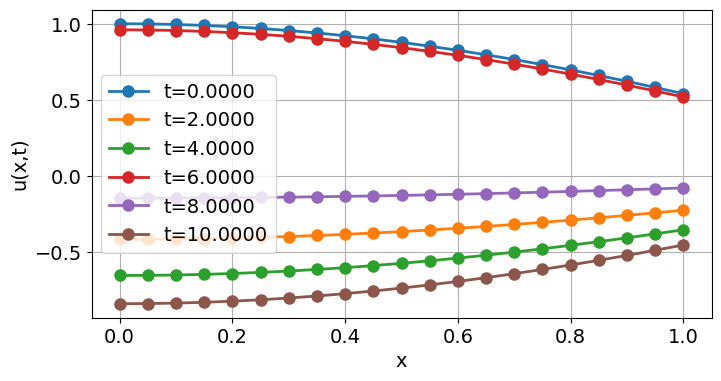

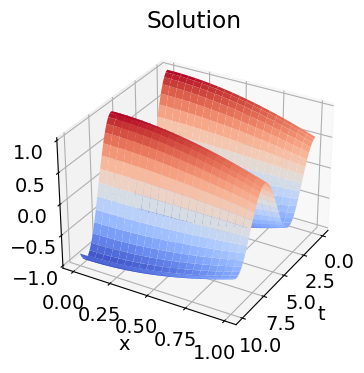

In [395]:
plt.figure(1)
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x,U[:,n],'-o',label='t={:.4f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()
# Make a 3-d plot
plot_solution(x, t, U, txt='Solution')
plt.show()

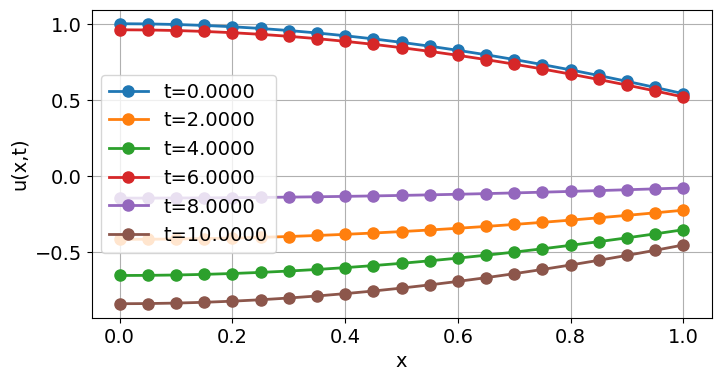

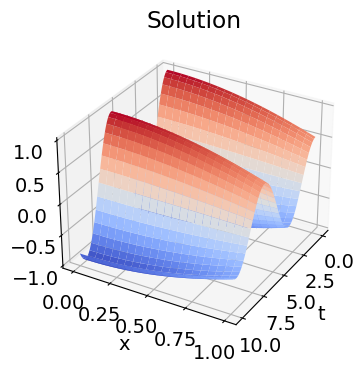

In [396]:
tv,xv = np.meshgrid(t,x)
Y = u(xv,tv)
plt.figure(2)
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x,Y[:,n],'-o',label='t={:.4f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()
# Make a 3-d plot
plot_solution(x,t,Y)

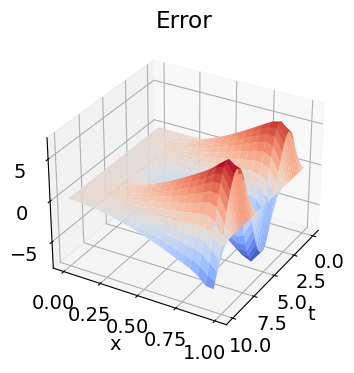

7.977444353157725e-07

In [397]:
# Make a 3-d plot of the error
T, X = np.meshgrid(t,x)
plot_solution(x, t, U-Y, txt='Error')
plt.show()
np.max(np.abs(U-Y))


In [398]:
def convergence_space(u_exact,object, solver=crank_nicholson): 
    P = 4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 4
    for p in range(P):
        x, t, U = solver(object, M=M, N=10000, T=1)
        Eh = u_exact(x,t[-1])-U[:,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order


In [399]:
H, E, p = convergence_space(u,ex1)
import pandas as pd #To format the output of the notebook.  
Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': H, 'Error': E ,'Rate':Rate}) 
df

h=0.2500, k=0.0001
h=0.1250, k=0.0001
h=0.0625, k=0.0001
h=0.0312, k=0.0001


,h,Error,Rate
0,0.25000000,0.00001059,0.00000000
1,0.12500000,0.00000331,1.67678886
2,0.06250000,0.00000085,1.95469394
3,0.03125000,0.00000022,1.93782004


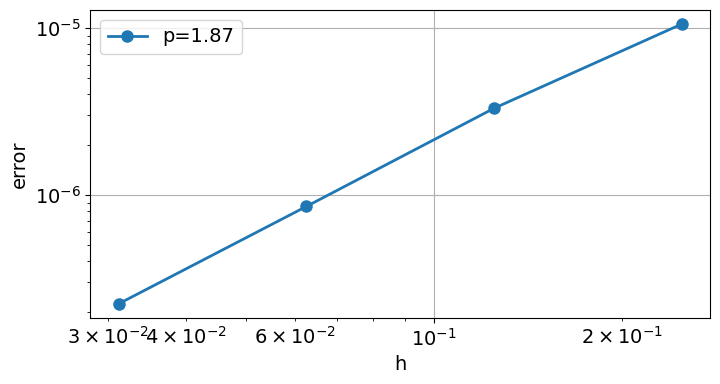

In [400]:
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

In [401]:
# Find reference solution for semidiscrete problem (h fixed)
x, t, U_ref = crank_nicholson(ex1, M=20, N=50000, T=1)

# Refine in time
def convergence_time(U_ref, object,solver=crank_nicholson): 
    P = 4
    Tconv = np.zeros(P)
    Econv = np.zeros(P)
    N = 400
    for p in range(P):
        x, t, U = solver(object, M=20, N=N, T=1)
        Eh = U_ref[:,-1]-U[:,-1]
        Tconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N = 2*N
    order = np.polyfit(np.log(Tconv),np.log(Econv),1)[0]
    return Tconv, Econv, order

h=0.0500, k=0.0000


In [402]:
T, E, p = convergence_time(U_ref,ex1)

Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(T[1:]/T[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'k': T, 'Error': E ,'Rate':Rate}) 
df

h=0.0500, k=0.0025
h=0.0500, k=0.0013
h=0.0500, k=0.0006
h=0.0500, k=0.0003


,k,Error,Rate
0,0.00250000,0.00000023,0.00000000
1,0.00125000,0.00000006,2.00029403
2,0.00062500,0.00000001,2.00117133
3,0.00031250,0.00000000,2.00470441


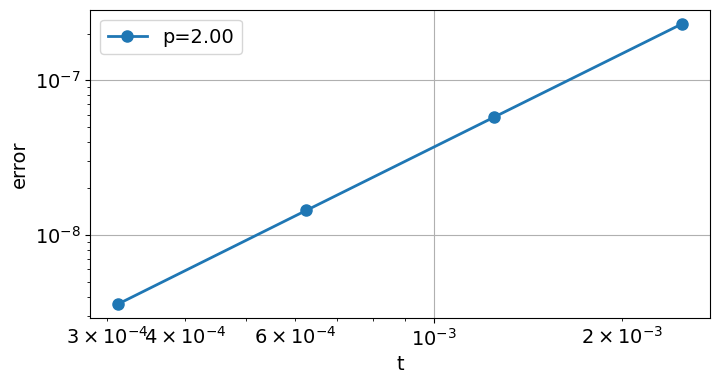

In [403]:
plt.loglog(T,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('t')
plt.ylabel('error')
plt.legend();

In [404]:
K = 1
R_max = 20
s = 0.5
r = 0.3**2
c = 0.8

def ga(x):
    return 0*x
def f(x,y):
    return 0*x
# def u0(x):
#     return np.sign(x-K) # Binary call
def u0(x):
    a = x>K
    return a*(x-K)        # European call
def gb(x):
    return u0(R_max)+0*x


ex_max = IBVP(ga,gb,0,R_max,u0,f,s,r,c)

M_max = 200
N = 1000
h = R_max/M_max
x_max,t_max,U_max = crank_nicholson(ex_max, M=M_max, N=N, T=5)
m_2K = int(2*K*M_max/R_max)
print(m_2K)

h=0.1000, k=0.0050
20


In [405]:

Ms = np.array([30,50,70,90,110,130,150,170,190])
Rs = Ms*h
print(Rs)
E = np.zeros((len(Rs),len(t_max)))
for i,R in enumerate(Rs):
    def gb(x):
        return u0(R)+0*x
    print(i,R)
    ex_R = IBVP(ga,gb,0,R,u0,f,s,r,c)
    x,t,U = crank_nicholson(ex_R, M = Ms[i], N = N, T=5)
    E[i]=np.max(abs(U[0:m_2K]-U_max[0:m_2K]),axis=0)

    

[ 3.  5.  7.  9. 11. 13. 15. 17. 19.]
0 3.0
h=0.1000, k=0.0050
1 5.0
h=0.1000, k=0.0050
2 7.0
h=0.1000, k=0.0050
3 9.0
h=0.1000, k=0.0050
4 11.0
h=0.1000, k=0.0050
5 13.0
h=0.1000, k=0.0050
6 15.0
h=0.1000, k=0.0050
7 17.0
h=0.1000, k=0.0050
8 19.0
h=0.1000, k=0.0050


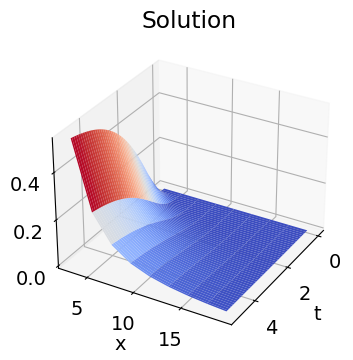

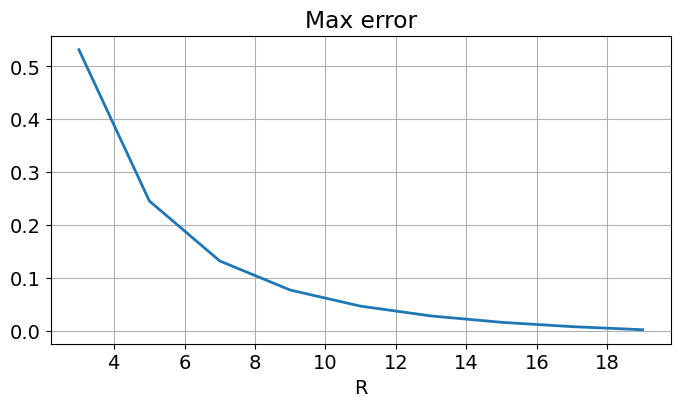

0.0022836403050394416

In [406]:

plt.figure()
plot_solution(Rs,t_max,E)

plt.figure(1)
plt.plot(Rs,np.max(E,axis =1 ))
plt.title('Max error')
plt.xlabel('R')
plt.show()

E[-1,-1]

Larger $R$ gives smaller error wrt the reference solution.

In [407]:
# Refined solution

def gb(x):
    return u0(R_max)+0*x

ex_max2 = IBVP(ga,gb,0,R_max,u0,f,s,r,c)

M_max2 = 500
N2 = 2000
h2 = R_max/M_max2
x_max2,t_max2,U_max2 = crank_nicholson(ex_max2, M=M_max2, N=N2, T=5)
m_2K2 = int(2*K*M_max2/R_max)
print(m_2K2)

h=0.0400, k=0.0025
50


In [408]:
Ms2 = np.array(range(m_2K2+10,M_max2,60))
Rs2 = Ms2*h2
print(Rs2)
E2 = np.zeros((len(Rs2),len(t_max2)))
for i,R in enumerate(Rs2):
    def gb(x):
        return u0(R)+0*x
    ex_R = IBVP(ga,gb,0,R,u0,f,s,r,c)
    x,t,U = crank_nicholson(ex_R, M = Ms2[i], N = N2, T=5)
    E2[i]=np.max(abs(U[0:m_2K2]-U_max2[0:m_2K2]),axis=0)


[ 2.4  4.8  7.2  9.6 12.  14.4 16.8 19.2]
h=0.0400, k=0.0025
h=0.0400, k=0.0025
h=0.0400, k=0.0025
h=0.0400, k=0.0025
h=0.0400, k=0.0025
h=0.0400, k=0.0025
h=0.0400, k=0.0025
h=0.0400, k=0.0025


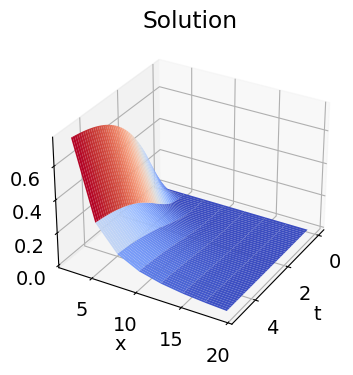

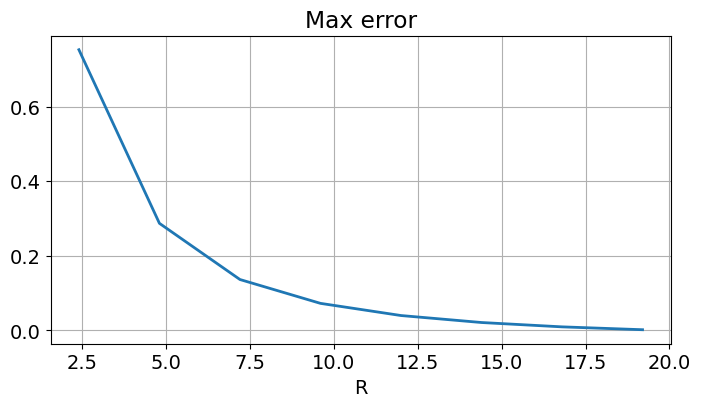

0.0019773895736199254

In [409]:

plt.figure()
plot_solution(Rs2,t_max2,E2)

plt.figure(1)
plt.plot(Rs2,np.max(E2,axis =1 ))
plt.title('Max error')
plt.xlabel('R')
plt.show()

E2[-1,-1]

The two refinements seem to go to zero about as fast